## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score, make_scorer, classification_report
import sqlite3
import datetime
import scikitplot as skplt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec

global_start = datetime.datetime.now()

## Intuitive understanding of naive bayes

In [19]:
s = ['abc def abc def', 'abc pqr pqr pqr cdf', 'abc def pqr abc', 'pqr not def']
y = [0,1,0,1]
bow = CountVectorizer(binary=False)
count_vec = bow.fit_transform(s)
df = pd.DataFrame(data=count_vec.toarray(), columns=bow.get_feature_names())
df['y'] = y
df

,abc,cdf,def,not,pqr,y
0,1,0,1,0,0,0
1,1,1,0,0,1,1
2,1,0,1,0,1,0
3,0,0,1,1,1,1


In [33]:
clf = MultinomialNB(alpha=1)
clf.fit(count_vec, y)
np.exp(clf.class_log_prior_)

array([0.5, 0.5])

In [34]:
clf.feature_count_

array([[2., 0., 2., 0., 1.],
       [1., 1., 1., 1., 2.]])

In [35]:
np.exp(clf.feature_log_prob_)

array([[0.3       , 0.1       , 0.3       , 0.1       , 0.2       ],
       [0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.27272727]])

## Read data into Pandas dataframe

In [27]:
conn = sqlite3.connect('final.sqlite')
data = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
conn.close()

print('Shape of our data : {}'.format(data.shape))
data.head(3)    

Shape of our data : (364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


## Randomly Sample 100k points from 364k points

In [28]:
sample_data = data.sample(n=100000, random_state=42).reset_index(drop=True)
del data # To free up the RAM
print('shape of our sampled data : {}'.format(sample_data.shape))
print('\n Distribution of class label : \n{}'.format(sample_data['Score'].value_counts(normalize=True)))
sample_data.head(3)

shape of our sampled data : (100000, 11)

 Distribution of class label : 
positive    0.84356
negative    0.15644
Name: Score, dtype: float64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,474309,B003L1XMAA,A2BS25CMKABXK5,"Lela ""Lela""",4,4,positive,1309996800,Delicious,Too busy enjoying this wonderful lavender extr...,busy enjoying wonderful lavender extract homem...
1,474247,B005IU1NLC,A1OTUKJ8298TY5,Elizabeth MccArthy,0,0,positive,1317600000,So yummy,These are sooooo good! I had to find them on h...,sooooo good find since sell single packet supe...
2,343379,B00004RBDU,A28ZA79VMCI8W1,"Linda Khan ""kittykatkhan""",2,2,positive,1257206400,Flea Trap WORKS!,"In the past, I have used a metal type flea tra...",past used metal type flea trap owned operated ...


## Create a feature based on length of the Review

In [29]:
sample_data['length'] = sample_data['Text'].apply(lambda x : len(x))
sample_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,length
0,474309,B003L1XMAA,A2BS25CMKABXK5,"Lela ""Lela""",4,4,positive,1309996800,Delicious,Too busy enjoying this wonderful lavender extr...,busy enjoying wonderful lavender extract homem...,170
1,474247,B005IU1NLC,A1OTUKJ8298TY5,Elizabeth MccArthy,0,0,positive,1317600000,So yummy,These are sooooo good! I had to find them on h...,sooooo good find since sell single packet supe...,143
2,343379,B00004RBDU,A28ZA79VMCI8W1,"Linda Khan ""kittykatkhan""",2,2,positive,1257206400,Flea Trap WORKS!,"In the past, I have used a metal type flea tra...",past used metal type flea trap owned operated ...,759


## Time Based Splitting
We arrange the sampled data in ascending order of **Time** column and split the data without shuffling such that:
* Train_data = First 70%
* Test_data = Last 30%

In [30]:
# Sort by Time
sample_data = sample_data.sort_values('Time').reset_index(drop=True)

X_text = sample_data.iloc[:,10] # Selecting the 'CleanedText' column
y = sample_data.iloc[:,6] # Selecting the 'Score' column

# Split the data
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.30, shuffle=False)

# Sanity check
print('Shape of X_text_train : {}'.format(X_text_train.shape))
print('Shape of y_train : {}'.format(y_train.shape))
print()
print('Shape of X_text_test : {}'.format(X_text_test.shape))
print('Shape of y_test : {}'.format(y_test.shape))

Shape of X_text_train : (70000,)
Shape of y_train : (70000,)

Shape of X_text_test : (30000,)
Shape of y_test : (30000,)


## Modelling
We will Create a **Naive Bayes** based classification model using the following features:
* **Binary Bag Of Words** - Bernoulli Naive Bayes
* **Count based Bag Of words** - Multinomial Naive Bayes
* **TFIDF** - Multinomial Naive Bayes

In [31]:
# Make a custom f1 scorer
scorer = make_scorer(f1_score, average='weighted')

### Cross Validation

In [32]:
# The following function performs hyperparameter tuning using cross-validation.
# We will find the optimum value of alpha by finding the hight weighted f-1 score
def nb_cv(X_train, y_train, bernoulli=False, calculate_class_priors=True):
    
    start = datetime.datetime.now()
    
    # values of alphas to iterate over.
    alpha_values = np.linspace(0.01, 0.1, 10)
    
    # creating a stratified Kfold object
    skf = StratifiedKFold(n_splits=10)
    
    # To store f1-scores corresponding to each alpha.
    cv_f1_scores = {}
    
    # perform 10-fold cross validation
    if bernoulli:
        for alpha in alpha_values:
            clf = BernoulliNB(alpha=alpha, fit_prior=calculate_class_priors)
            f1_score = cross_val_score(clf, X_train, y_train, cv=skf, scoring=scorer).mean()
            cv_f1_scores[alpha] = f1_score
           
    else:
        for alpha in alpha_values:
            clf = MultinomialNB(alpha=alpha, fit_prior=calculate_class_priors)
            f1_score = cross_val_score(clf, X_train, y_train, cv=skf, scoring=scorer).mean()
            cv_f1_scores[alpha] = f1_score
    
       
    # Find the optimal alpha
    optimal_alpha = max(cv_f1_scores, key=cv_f1_scores.get)
    
    # Plot alpha v/s f1-score
    plt.figure(figsize=(12,6))
    plt.plot(cv_f1_scores.keys(), cv_f1_scores.values())
    plt.xlabel('Alpha')
    plt.ylabel('weighted f1-score')
    plt.title('f1-score v/s alpha')
    plt.show()

    print('The optimum value of alpha based on cross-validation is : {}'.format(optimal_alpha))
    print('Time taken : {}'.format(datetime.datetime.now() - start))
    
    return optimal_alpha

### Generate classification reports

In [33]:
# The following fucntion generates classification reports based on Test data predictions
def evaluate_test_predictions(y_test, y_pred):
    print('\n########## CLASSIFICATION REPORTS ON TEST DATA##########')
    print('accuracy on test data : {}'.format(accuracy_score(y_test, y_pred)))
    print()
    print(classification_report(y_test, y_pred))
    print()
    print()
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    

### Print important features

In [34]:
def print_feature_importance(clf, featurizer):
    neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()[::-1]
    pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()[::-1]

    print('negative class words :',np.take(featurizer.get_feature_names(), neg_class_prob_sorted[:10]))
    print('positive class words :',np.take(featurizer.get_feature_names(), pos_class_prob_sorted[:10]))
    

## Binary Bag of Words + Bernoulli NB + True_class_priors

Type of X_train : <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_train : (70000, 47863)
Number of unique words : 47863


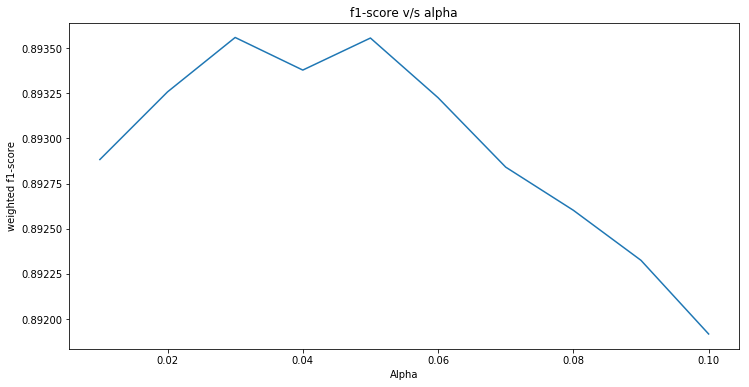

The optimum value of alpha based on cross-validation is : 0.030000000000000006
Time taken : 0:01:05.714440

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8912

              precision    recall  f1-score   support

    negative       0.71      0.65      0.67      5242
    positive       0.93      0.94      0.93     24758

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.82      0.79      0.80     30000
weighted avg       0.89      0.89      0.89     30000



negative class words : ['not' 'like' 'would' 'taste' 'product' 'one' 'good' 'flavor' 'get' 'even']
positive class words : ['not' 'like' 'good' 'great' 'one' 'taste' 'love' 'product' 'flavor'
 'would']


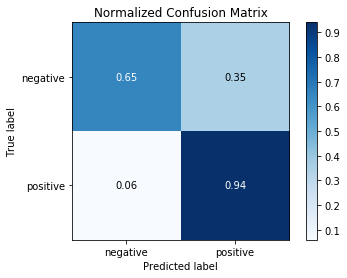

In [10]:
# ************** Creating Bag Of Words ***************************
count_vec = CountVectorizer(binary=True)
X_train = count_vec.fit_transform(X_text_train)
print('Type of X_train : {}'.format(type(X_train)))
print('Shape of X_train : {}'.format(X_train.get_shape()))
print('Number of unique words : {}'.format(X_train.get_shape()[1]))

# cross validation
optimal_alpha = nb_cv(X_train, y_train, bernoulli=True, calculate_class_priors=True)

# Predictions on test data
X_test = count_vec.transform(X_text_test)
clf = BernoulliNB(alpha=optimal_alpha)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)

print_feature_importance(clf,count_vec)

## Binary Bag of Words + Bernoulli NB + uniform_class_priors

Type of X_train : <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_train : (70000, 47863)
Number of unique words : 47863


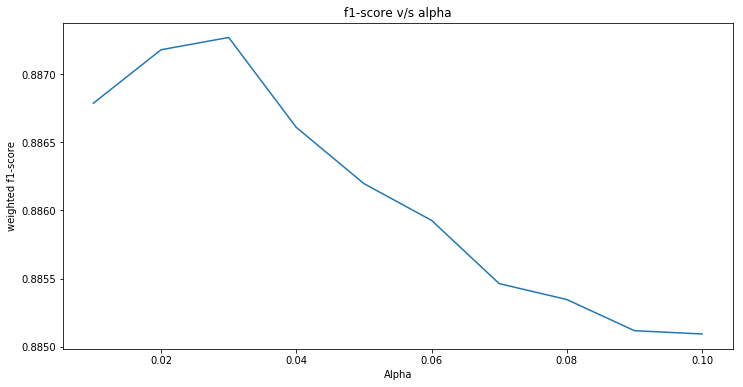

The optimum value of alpha based on cross-validation is : 0.030000000000000006
Time taken : 0:01:15.279139

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8815333333333333

              precision    recall  f1-score   support

    negative       0.63      0.76      0.69      5242
    positive       0.95      0.91      0.93     24758

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.79      0.83      0.81     30000
weighted avg       0.89      0.88      0.89     30000



negative class words : ['not' 'like' 'would' 'taste' 'product' 'one' 'good' 'flavor' 'get' 'even']
positive class words : ['not' 'like' 'good' 'great' 'one' 'taste' 'love' 'product' 'flavor'
 'would']


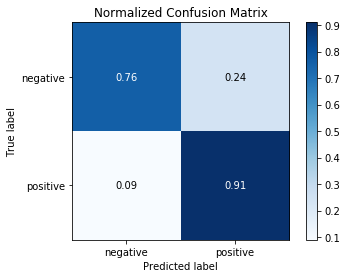

In [11]:
# ************** Creating Bag Of Words ***************************
count_vec = CountVectorizer(binary=True)
X_train = count_vec.fit_transform(X_text_train)
print('Type of X_train : {}'.format(type(X_train)))
print('Shape of X_train : {}'.format(X_train.get_shape()))
print('Number of unique words : {}'.format(X_train.get_shape()[1]))

# cross validation
optimal_alpha = nb_cv(X_train, y_train, bernoulli=True, calculate_class_priors=False)

# Predictions on test data
X_test = count_vec.transform(X_text_test)
clf = BernoulliNB(alpha=optimal_alpha,fit_prior=False)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)

print_feature_importance(clf,count_vec)

## Count based BOW + MultinomialNB + True_class_priors

Type of X_train : <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_train : (70000, 47863)
Number of unique words : 47863


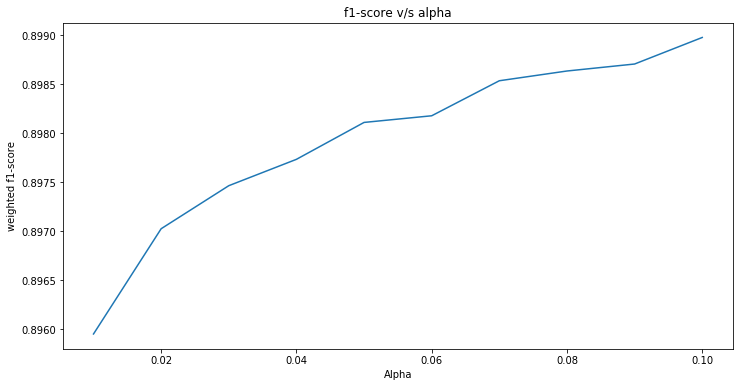

The optimum value of alpha based on cross-validation is : 0.1
Time taken : 0:01:01.253570

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8980666666666667

              precision    recall  f1-score   support

    negative       0.71      0.71      0.71      5242
    positive       0.94      0.94      0.94     24758

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.82      0.82      0.82     30000
weighted avg       0.90      0.90      0.90     30000



negative class words : ['not' 'like' 'would' 'taste' 'product' 'one' 'good' 'flavor' 'coffee'
 'tea']
positive class words : ['not' 'like' 'good' 'great' 'one' 'taste' 'tea' 'flavor' 'product' 'love']


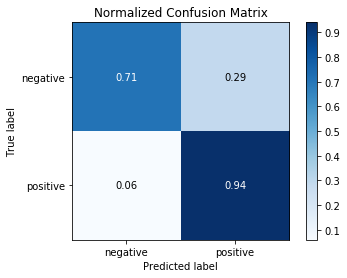

In [12]:
# ************** Creating Bag Of Words ***************************
count_vec = CountVectorizer()
X_train = count_vec.fit_transform(X_text_train)
print('Type of X_train : {}'.format(type(X_train)))
print('Shape of X_train : {}'.format(X_train.get_shape()))
print('Number of unique words : {}'.format(X_train.get_shape()[1]))

# cross validation
optimal_alpha = nb_cv(X_train, y_train, bernoulli=False, calculate_class_priors=True)

# Predictions on test data
X_test = count_vec.transform(X_text_test)
clf = MultinomialNB(alpha=optimal_alpha)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)

print_feature_importance(clf,count_vec)

##  Count based BOW + MultinomialNB + Uniform_class_priors

Type of X_train : <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_train : (70000, 47863)
Number of unique words : 47863


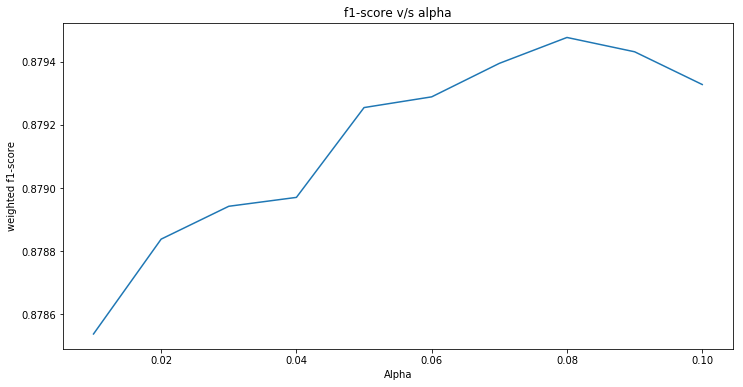

The optimum value of alpha based on cross-validation is : 0.08
Time taken : 0:00:59.305004

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8750666666666667

              precision    recall  f1-score   support

    negative       0.61      0.81      0.69      5242
    positive       0.96      0.89      0.92     24758

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.78      0.85      0.81     30000
weighted avg       0.90      0.88      0.88     30000



negative class words : ['not' 'like' 'would' 'taste' 'product' 'one' 'good' 'flavor' 'coffee'
 'tea']
positive class words : ['not' 'like' 'good' 'great' 'one' 'taste' 'tea' 'flavor' 'product' 'love']


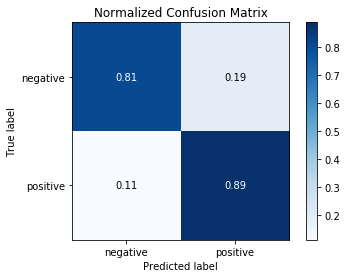

In [35]:
# ************** Creating Bag Of Words ***************************
count_vec = CountVectorizer()
X_train = count_vec.fit_transform(X_text_train)
print('Type of X_train : {}'.format(type(X_train)))
print('Shape of X_train : {}'.format(X_train.get_shape()))
print('Number of unique words : {}'.format(X_train.get_shape()[1]))

# cross validation
optimal_alpha = nb_cv(X_train, y_train, bernoulli=False, calculate_class_priors=False)

# Predictions on test data
X_test = count_vec.transform(X_text_test)
clf = MultinomialNB(alpha=optimal_alpha, fit_prior=False)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)

print_feature_importance(clf,count_vec)

## TFIDF + MultinomialNB + true_class_priors

Type of X_train : <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_train : (70000, 47863)
Number of unique words : 47863


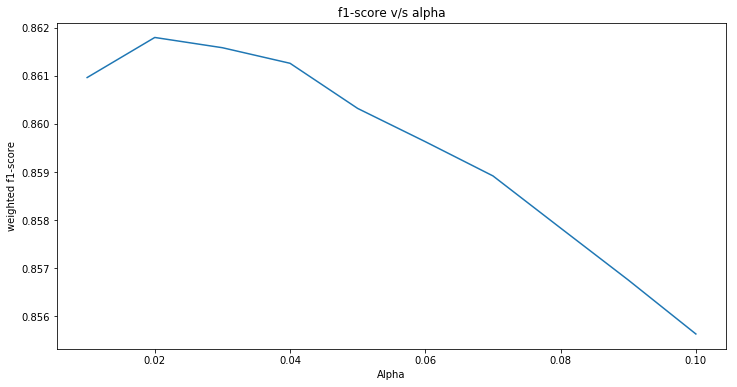

The optimum value of alpha based on cross-validation is : 0.020000000000000004
Time taken : 0:01:02.440533

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8685

              precision    recall  f1-score   support

    negative       0.88      0.29      0.43      5242
    positive       0.87      0.99      0.93     24758

   micro avg       0.87      0.87      0.87     30000
   macro avg       0.87      0.64      0.68     30000
weighted avg       0.87      0.87      0.84     30000



negative class words : ['not' 'like' 'taste' 'product' 'would' 'coffee' 'one' 'flavor' 'good'
 'tea']
positive class words : ['not' 'great' 'good' 'like' 'tea' 'coffee' 'love' 'product' 'taste' 'one']


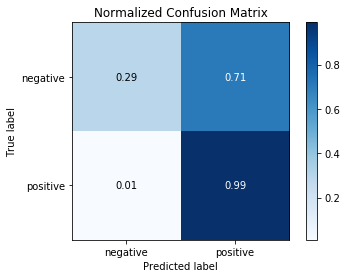

In [14]:
# ************** Creating TFIDF ***************************
tfidf_vec = TfidfVectorizer()
X_train = tfidf_vec.fit_transform(X_text_train)
print('Type of X_train : {}'.format(type(X_train)))
print('Shape of X_train : {}'.format(X_train.get_shape()))
print('Number of unique words : {}'.format(X_train.get_shape()[1]))

# cross validation
optimal_alpha = nb_cv(X_train, y_train, bernoulli=False, calculate_class_priors=True)

# Predictions on test data
X_test = tfidf_vec.transform(X_text_test)
clf = MultinomialNB(alpha=optimal_alpha, fit_prior=True)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)

print_feature_importance(clf,tfidf_vec)

## TFIDF + MultinomialNB + uniform_class_priors¶

Type of X_train : <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_train : (70000, 47863)
Number of unique words : 47863


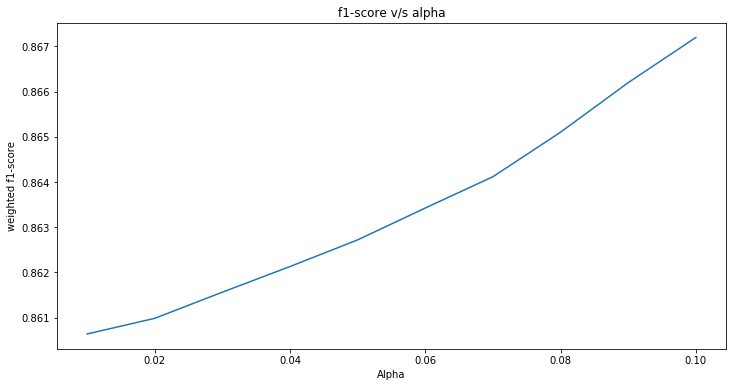

The optimum value of alpha based on cross-validation is : 0.1
Time taken : 0:00:58.381342

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8741

              precision    recall  f1-score   support

    negative       0.61      0.78      0.68      5242
    positive       0.95      0.89      0.92     24758

   micro avg       0.87      0.87      0.87     30000
   macro avg       0.78      0.84      0.80     30000
weighted avg       0.89      0.87      0.88     30000



negative class words : ['not' 'like' 'taste' 'product' 'would' 'coffee' 'one' 'flavor' 'good'
 'tea']
positive class words : ['not' 'great' 'good' 'like' 'tea' 'coffee' 'love' 'product' 'taste' 'one']


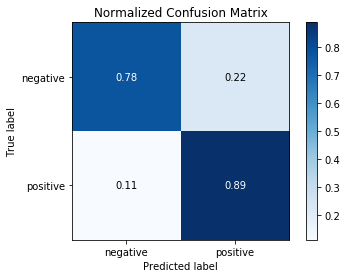

In [15]:
# ************** Creating TFIDF ***************************
tfidf_vec = TfidfVectorizer()
X_train = tfidf_vec.fit_transform(X_text_train)
print('Type of X_train : {}'.format(type(X_train)))
print('Shape of X_train : {}'.format(X_train.get_shape()))
print('Number of unique words : {}'.format(X_train.get_shape()[1]))

# cross validation
optimal_alpha = nb_cv(X_train, y_train, bernoulli=False, calculate_class_priors=False)

# Predictions on test data
X_test = tfidf_vec.transform(X_text_test)
clf = MultinomialNB(alpha=optimal_alpha, fit_prior=False)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)

print_feature_importance(clf,tfidf_vec)

##  Count based BOW + Review Length + MultinomialNB + Uniform_class_priors

In [16]:
# **************** Create train and test data ********************
X_text = sample_data.iloc[:,[10,11]] # Selecting the 'CleanedText' and 'length' column.
y = sample_data.iloc[:,6] # Selecting the 'Score' column

# Split the data
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.30, shuffle=False)

# Sanity check
print('Shape of X_text_train : {}'.format(X_text_train.shape))
print('Shape of y_train : {}'.format(y_train.shape))
print()
print('Shape of X_text_test : {}'.format(X_text_test.shape))
print('Shape of y_test : {}'.format(y_test.shape))

# ************** Creating Bag Of Words ***************************
count_vec = CountVectorizer()
X_train_bow = count_vec.fit_transform(X_text_train['CleanedText'])
print('\nType of X_train_bow : {}'.format(type(X_train_bow)))
print('Shape of X_train_bow : {}'.format(X_train_bow.get_shape()))
print('Number of unique words : {}'.format(X_train_bow.get_shape()[1]))

# ***************** Adding the length column to CSR Matrix in train data *********
X_train = hstack((X_train_bow,X_text_train['length'][:, None]),format='csr')
print('\nShape of X_train : {}'.format(X_train.get_shape()))

Shape of X_text_train : (70000, 2)
Shape of y_train : (70000,)

Shape of X_text_test : (30000, 2)
Shape of y_test : (30000,)

Type of X_train_bow : <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_train_bow : (70000, 47863)
Number of unique words : 47863

Shape of X_train : (70000, 47864)


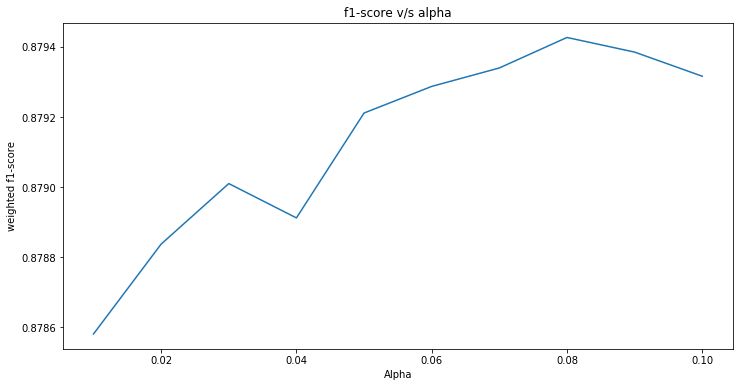

The optimum value of alpha based on cross-validation is : 0.08
Time taken : 0:01:05.531537


In [17]:
# cross validation
optimal_alpha = nb_cv(X_train, y_train, bernoulli=False, calculate_class_priors=False)

Shape of X_test : (30000, 47864)

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8750666666666667

              precision    recall  f1-score   support

    negative       0.61      0.81      0.69      5242
    positive       0.96      0.89      0.92     24758

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.78      0.85      0.81     30000
weighted avg       0.90      0.88      0.88     30000



negative class words : ['not' 'like' 'would' 'taste' 'product' 'one' 'good' 'flavor' 'coffee'
 'tea']
positive class words : ['not' 'like' 'good' 'great' 'one' 'taste' 'tea' 'flavor' 'product' 'love']


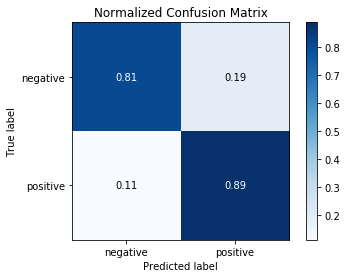

In [18]:
# **************Make Predictions on Test data***********

# Create Test Data
X_test_bow = count_vec.transform(X_text_test['CleanedText'])
X_test = hstack((X_test_bow,X_text_test['length'][:, None]),format='csr')
print('Shape of X_test : {}'.format(X_test.get_shape()))

# Make Predictions on Test data
clf = MultinomialNB(alpha=optimal_alpha, fit_prior=False)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)

# Print feature importance
neg_class_prob_sorted = clf.feature_log_prob_[0, :-1].argsort()[::-1]
pos_class_prob_sorted = clf.feature_log_prob_[1, :-1].argsort()[::-1]
print('negative class words :',np.take(count_vec.get_feature_names(), neg_class_prob_sorted[:10]))
print('positive class words :',np.take(count_vec.get_feature_names(), pos_class_prob_sorted[:10]))